# 03: Metrics Visualization

This notebook demonstrates how to visualize experiment metrics using the yanex.results API.

## What You'll Learn

- Using the `yr.get_metrics()` function for multi-experiment visualization
- Controlling parameter inclusion with `include_params`
- Creating time-series plots for single and multiple experiments
- Handling metrics with different scales (loss vs accuracy)
- Comparing hyperparameter effects with grouped visualizations
- Creating grid search visualizations
- Plotting individual runs with averages


## Prerequisites

**Before running this notebook**, you need to create sample experiments using the multi-step metrics CLI example with a parameter sweep.

Run this command from the `examples/cli/05_multi_step_metrics/` directory:

```bash
cd examples/cli/05_multi_step_metrics
yanex run train_model.py \
  --param "epochs=10,20,30" \
  --param "learning_rate=logspace(-4, -1, 4)" \
  --param "batch_size=32" \
  --tag results-demo \
  --parallel 0
```

This creates **12 experiments** in parallel (3 epochs × 4 learning rates) with the tag `results-demo`. We'll use this tag to filter and analyze these specific experiments throughout this notebook.

**What this trains:**
- A simple neural network training simulation
- Logs metrics at each epoch: `train_loss`, `train_accuracy`
- Occasionally logs validation metrics: `val_loss`, `val_accuracy`
- Parameters: `epochs`, `learning_rate`, `batch_size`

In [16]:
import matplotlib.pyplot as plt

import yanex.results as yr

# Load experiments from the parameter sweep
experiments = yr.get_experiments(status="completed", tags=["results-demo"])

learning_rates = {e.get_param("learning_rate") for e in experiments}
epochs = {e.get_param("epochs") for e in experiments}

print(
    f"Loaded {len(experiments)} experiments, with the following parameter variations:"
)
print(f"  Learning rates: {sorted(learning_rates)}")
print(f"  Epochs: {sorted(epochs)}")

Loaded 12 experiments, with the following parameter variations:
  Learning rates: [0.0001, 0.001, 0.01, 0.1]
  Epochs: [10, 20, 30]


## Parameter Control

The `include_params` parameter controls which parameter columns are included:
- `'auto'` (default): Only parameters that vary across experiments
- `'all'`: All parameters
- `'none'`: No parameter columns
- `['lr', 'epochs']`: Specific list of parameters

In our example experiments, only `learning_rate` and `epochs` vary, while `batch_size` is constant (32).

In [17]:
# Compare different include_params options
print(
    "With include_params='auto' (default - only varying params `learning_rate` and `epochs`):"
)
df_auto = yr.get_metrics(tags=["results-demo"], include_params="auto")
display(df_auto.head(3))

print("With include_params='none' (no params):")
df_none = yr.get_metrics(tags=["results-demo"], include_params="none")
display(df_none.head(3))

print("With include_params='all' (all params including constant `batch_size`):")
df_all_params = yr.get_metrics(tags=["results-demo"], include_params="all")
display(df_all_params.head(3))

With include_params='auto' (default - only varying params `learning_rate` and `epochs`):


,experiment_id,step,metric_name,value,epochs,learning_rate
0,78562ccd,1,train_loss,2.023601,30,0.1
1,78562ccd,1,train_accuracy,0.475733,30,0.1
2,78562ccd,1,learning_rate,0.100000,30,0.1


With include_params='none' (no params):


,experiment_id,step,metric_name,value
0,78562ccd,1,train_loss,2.023601
1,78562ccd,1,train_accuracy,0.475733
2,78562ccd,1,learning_rate,0.100000


With include_params='all' (all params including constant `batch_size`):


,experiment_id,step,metric_name,value,batch_size,epochs,learning_rate
0,78562ccd,1,train_loss,2.023601,32,30,0.1
1,78562ccd,1,train_accuracy,0.475733,32,30,0.1
2,78562ccd,1,learning_rate,0.100000,32,30,0.1


## Use Case 1: Single Metric, Single Experiment

Plot one metric (e.g., train_loss) for a single experiment.

Experiment 78562ccd: lr=0.1, epochs=30
Metrics shape: (31, 9)


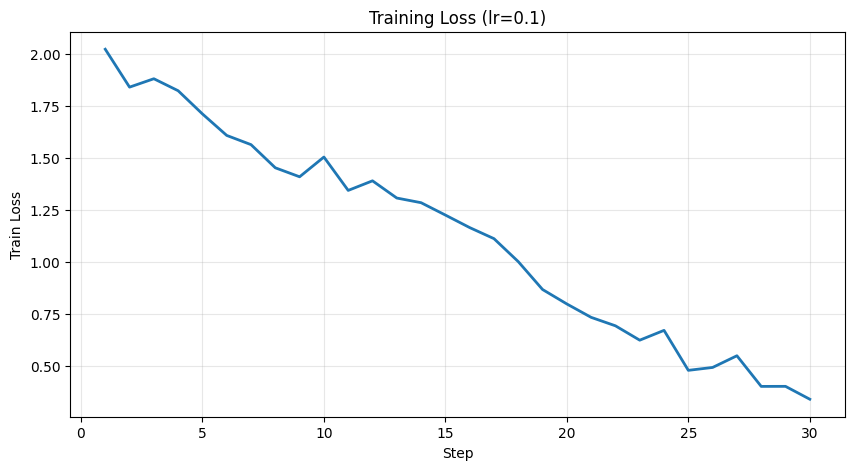

In [18]:
# Get metrics for a single experiment (returns DataFrame by default)
exp = experiments[0]
df = exp.get_metrics()

print(
    f"Experiment {exp.id}: lr={exp.get_param('learning_rate')}, epochs={exp.get_param('epochs')}"
)
print(f"Metrics shape: {df.shape}")

# Simple plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["train_loss"], linewidth=2)
plt.xlabel("Step")
plt.ylabel("Train Loss")
plt.title(f"Training Loss (lr={exp.get_param('learning_rate')})")
plt.grid(True, alpha=0.3)
plt.show()

## Use Case 2: Multiple Metrics, Single Experiment (Same Graph)

Plot train_loss and val_loss together to compare training vs validation performance.

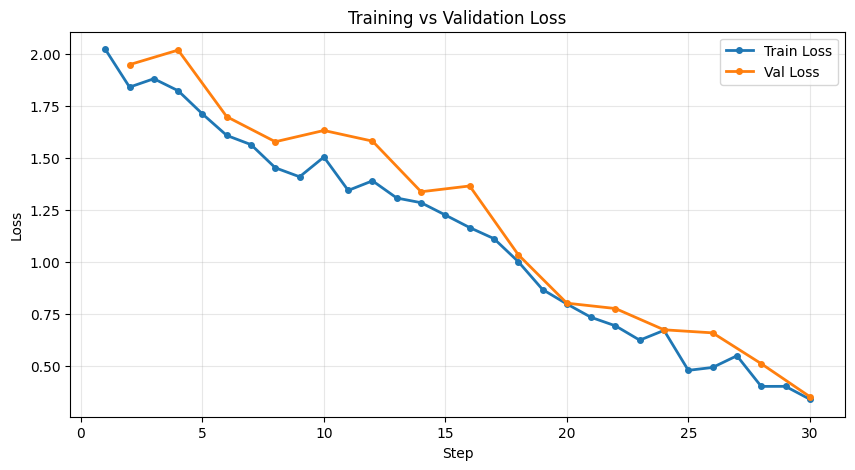

In [19]:
# Plot multiple metrics on the same graph

# Plot train_loss metric
plt.figure(figsize=(10, 5))
plt.plot(
    df.index,
    df["train_loss"],
    label="Train Loss",
    linewidth=2,
    marker="o",
    markersize=4,
)

# Note: val_loss is only logged every 2 steps, so we need to handle NaN values
val_loss_clean = df["val_loss"].dropna()
plt.plot(
    val_loss_clean.index,
    val_loss_clean.values,
    label="Val Loss",
    linewidth=2,
    marker="o",
    markersize=4,
)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Use Case 3: Multiple Metrics, Single Experiment (using subplots)

Plot train_loss and train_accuracy on separate subplots since they have different scales.

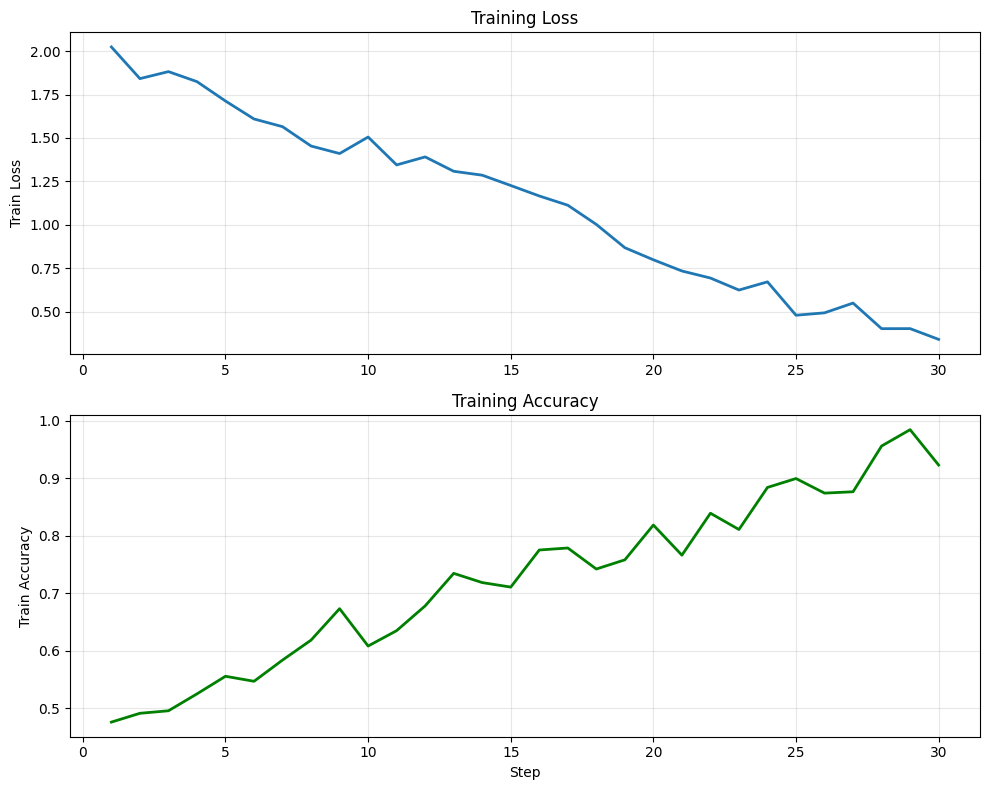

In [20]:
# Plot metrics with different scales on separate subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Loss subplot
ax1.plot(df.index, df["train_loss"], linewidth=2)
ax1.set_ylabel("Train Loss")
ax1.set_title("Training Loss")
ax1.grid(True, alpha=0.3)

# Accuracy subplot
ax2.plot(df.index, df["train_accuracy"], linewidth=2, color="green")
ax2.set_xlabel("Step")
ax2.set_ylabel("Train Accuracy")
ax2.set_title("Training Accuracy")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Use Case 4: Single Metric, Multiple Experiments

Compare a single metric (train_loss) across experiments with different hyperparameters.

This uses the new `yr.get_metrics()` function which returns long-format data optimized for grouping.

DataFrame shape: (984, 6)
Columns: ['experiment_id', 'step', 'metric_name', 'value', 'epochs', 'learning_rate']
Varying parameters: learning_rate, epochs


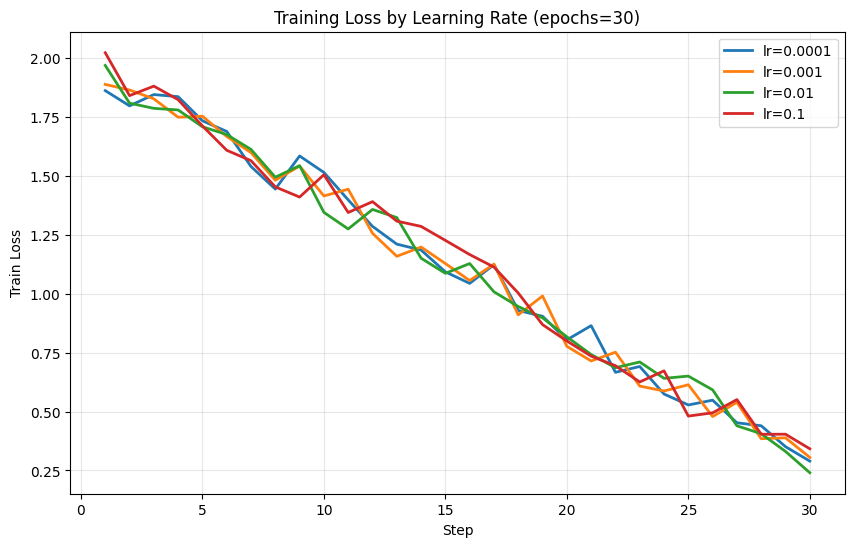

In [21]:
# Get metrics for all experiments
df_all = yr.get_metrics(tags=["results-demo"])

print(f"DataFrame shape: {df_all.shape}")
print(f"Columns: {list(df_all.columns)}")
print("Varying parameters: learning_rate, epochs")

# Filter to experiments with epochs=30 and plot by learning_rate
df_30 = df_all[df_all.epochs == 30]
df_loss = df_30[df_30.metric_name == "train_loss"]

plt.figure(figsize=(10, 6))
for lr, group in df_loss.groupby("learning_rate"):
    plt.plot(group.step, group.value, label=f"lr={lr}", linewidth=2)

plt.xlabel("Step")
plt.ylabel("Train Loss")
plt.title("Training Loss by Learning Rate (epochs=30)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Use Case 5: Multiple Metrics, Multiple Experiments (Different Scales)

Compare both train_loss and train_accuracy across different epoch settings.

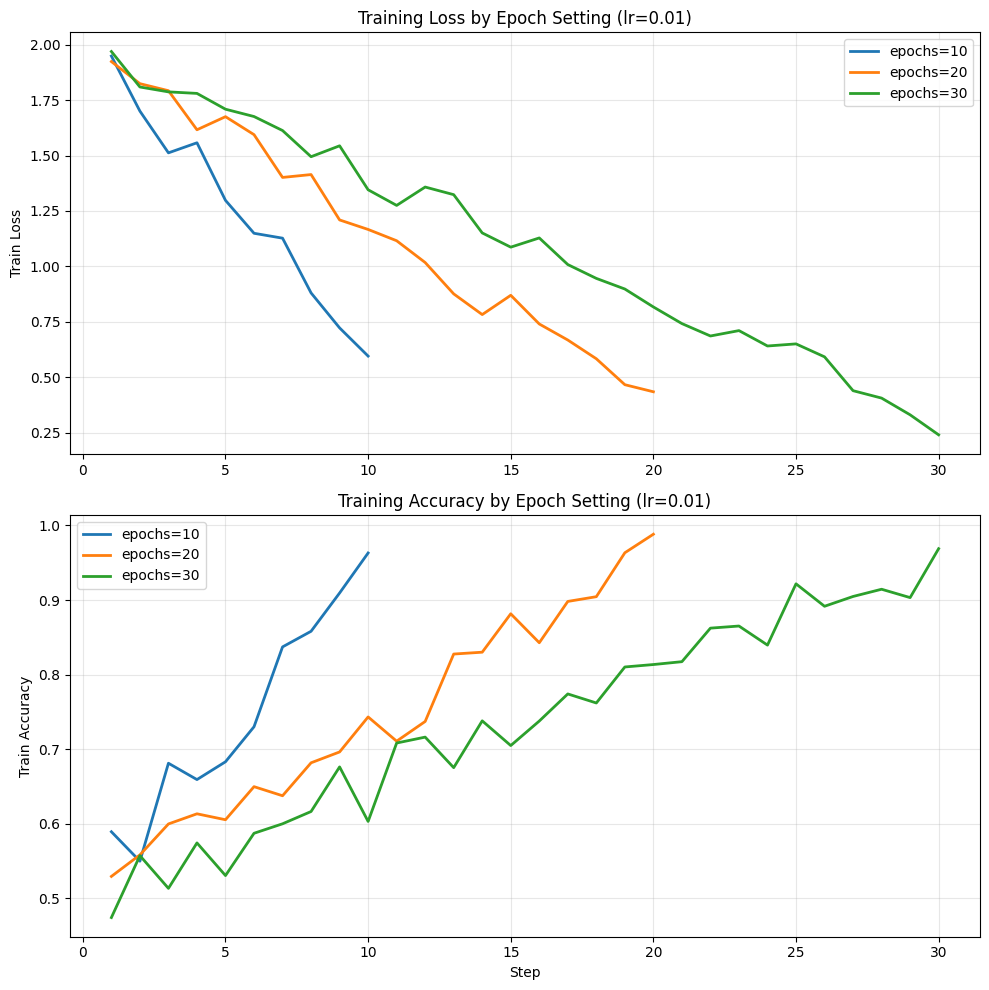

In [22]:
# Get metrics for all experiments
df_all = yr.get_metrics(tags=["results-demo"])

# Filter to lr=0.01 and compare different epoch settings
df_lr001 = df_all[df_all.learning_rate == 0.01]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot train_loss by epochs
df_loss = df_lr001[df_lr001.metric_name == "train_loss"]
for epochs, group in df_loss.groupby("epochs"):
    ax1.plot(group.step, group.value, label=f"epochs={epochs}", linewidth=2)
ax1.set_ylabel("Train Loss")
ax1.set_title("Training Loss by Epoch Setting (lr=0.01)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot train_accuracy by epochs
df_acc = df_lr001[df_lr001.metric_name == "train_accuracy"]
for epochs, group in df_acc.groupby("epochs"):
    ax2.plot(group.step, group.value, label=f"epochs={epochs}", linewidth=2)
ax2.set_xlabel("Step")
ax2.set_ylabel("Train Accuracy")
ax2.set_title("Training Accuracy by Epoch Setting (lr=0.01)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Use Case 6: Grid Search - Grouping by Multiple Parameters

When you have a grid search over multiple parameters, group by all parameter combinations.

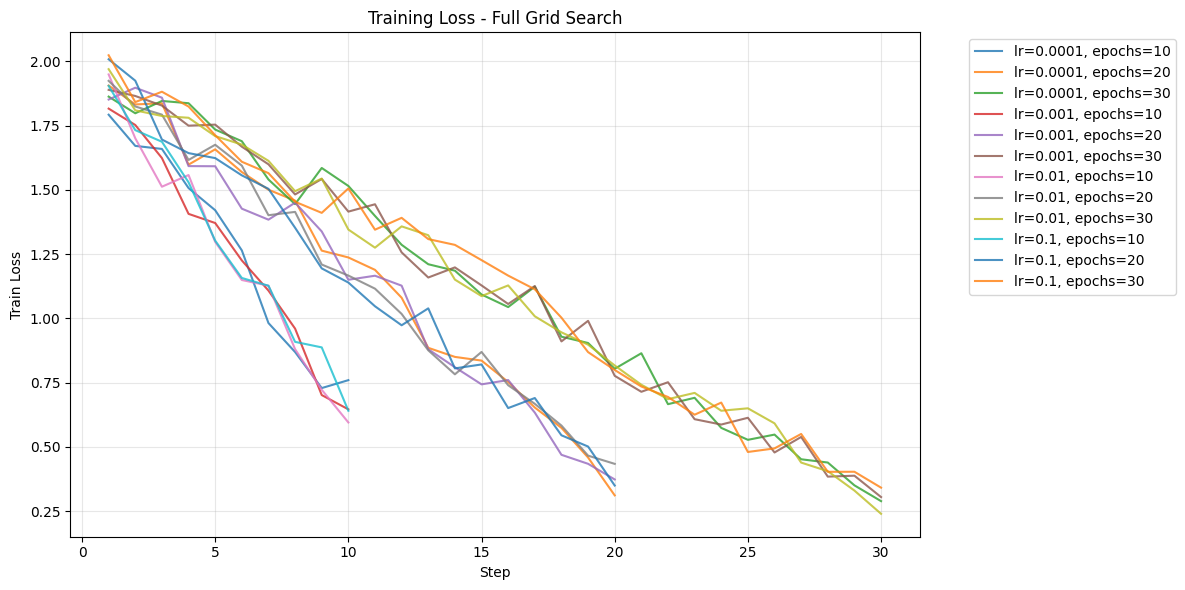

In [23]:
# Get metrics for all experiments
df_all = yr.get_metrics(tags=["results-demo"])

# Plot train_loss for all parameter combinations
df_loss_all = df_all[df_all.metric_name == "train_loss"]

plt.figure(figsize=(12, 6))

# Group by both learning_rate and epochs
for (lr, epochs), group in df_loss_all.groupby(["learning_rate", "epochs"]):
    plt.plot(
        group.step,
        group.value,
        label=f"lr={lr}, epochs={epochs}",
        linewidth=1.5,
        alpha=0.8,
    )

plt.xlabel("Step")
plt.ylabel("Train Loss")
plt.title("Training Loss - Full Grid Search")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

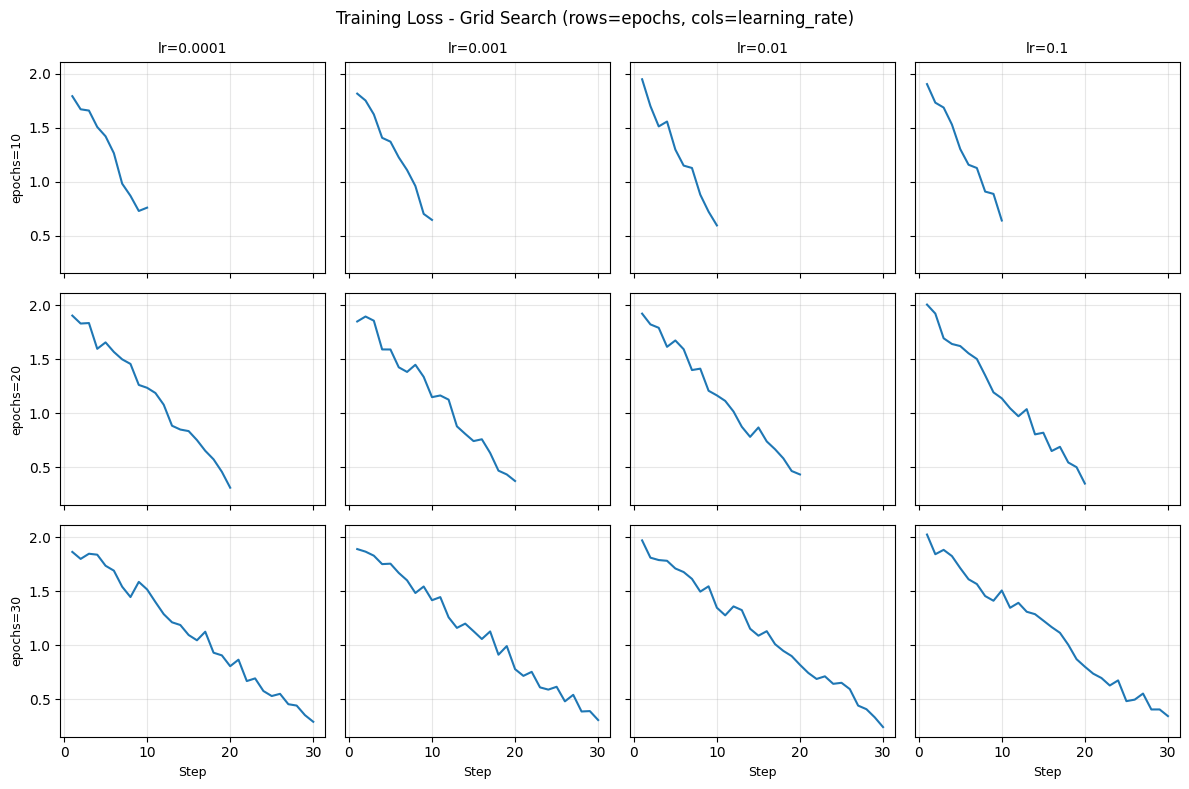

In [24]:
# Get metrics for all experiments
df_all = yr.get_metrics(tags=["results-demo"])
df_loss_all = df_all[df_all.metric_name == "train_loss"]

# Alternative: Grid of small subplots (one per parameter combination)
# 3 rows (epochs) × 4 columns (learning_rates)
learning_rates = sorted(df_loss_all.learning_rate.unique())
epochs_values = sorted(df_loss_all.epochs.unique())

fig, axes = plt.subplots(
    len(epochs_values), len(learning_rates), figsize=(12, 8), sharex=True, sharey=True
)

for i, epochs in enumerate(epochs_values):
    for j, lr in enumerate(learning_rates):
        ax = axes[i, j]

        # Filter to this specific parameter combination
        subset = df_loss_all[
            (df_loss_all.learning_rate == lr) & (df_loss_all.epochs == epochs)
        ]

        # Plot
        ax.plot(subset.step, subset.value, linewidth=1.5)
        ax.grid(True, alpha=0.3)

        # Labels
        if i == 0:
            ax.set_title(f"lr={lr}", fontsize=10)
        if j == 0:
            ax.set_ylabel(f"epochs={epochs}", fontsize=9)
        if i == len(epochs_values) - 1:
            ax.set_xlabel("Step", fontsize=9)

fig.suptitle(
    "Training Loss - Grid Search (rows=epochs, cols=learning_rate)", fontsize=12
)
plt.tight_layout()
plt.show()

## Use Case 7: Individual Runs + Average

Plot individual runs as faint lines and show the average as a thick line. This is useful when you have multiple runs per parameter setting (e.g., different learning rates for each epoch setting).

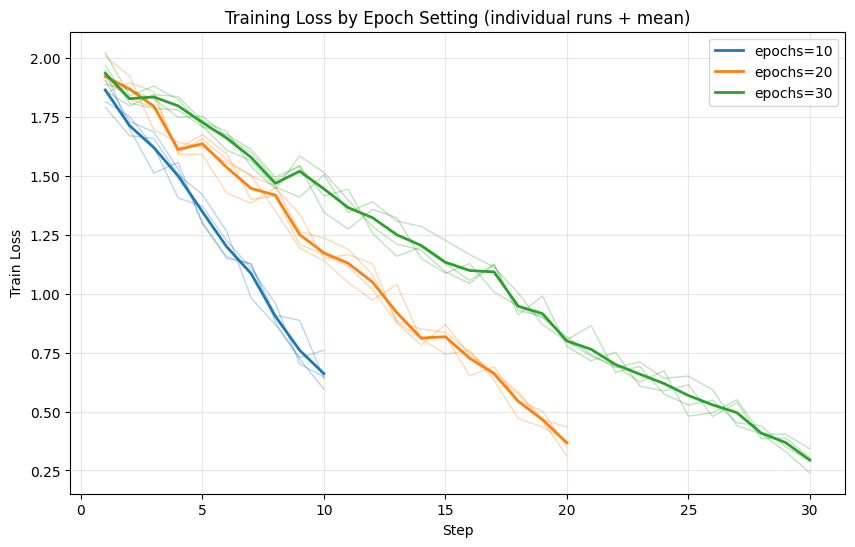

In [25]:
# Get metrics for all experiments
df_all = yr.get_metrics(tags=["results-demo"])
df_loss_all = df_all[df_all.metric_name == "train_loss"]

# For each epoch setting, plot individual runs (faint) and average (thick)
plt.figure(figsize=(10, 6))

for i, (epochs, epoch_group) in enumerate(df_loss_all.groupby("epochs")):
    color = f"C{i}"

    # Plot individual runs (one per learning rate) as faint lines
    for exp_id in epoch_group.experiment_id.unique():
        exp_data = epoch_group[epoch_group.experiment_id == exp_id]
        plt.plot(exp_data.step, exp_data.value, color=color, alpha=0.3, linewidth=1)

    # Calculate and plot the average across all runs
    avg = epoch_group.groupby("step")["value"].mean()
    plt.plot(avg.index, avg.values, color=color, linewidth=2, label=f"epochs={epochs}")

plt.xlabel("Step")
plt.ylabel("Train Loss")
plt.title("Training Loss by Epoch Setting (individual runs + mean)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Use Case 8: Box Plot of Final Metric Values

Compare distributions of final metric values across parameter settings. This is useful for understanding the impact of hyperparameters on final performance.

Final accuracy values per experiment:
experiment_id  epochs  learning_rate    value
     0bcd19c2      20         0.0001 0.905482
     129daf0a      30         0.0010 0.922358
     78562ccd      30         0.1000 0.922566
     8a97697d      30         0.0100 0.968834
     a0657dd5      20         0.0010 0.979099
     a31569cf      20         0.1000 0.980997
     a7cbb93d      10         0.0001 0.911454
     afbd5816      30         0.0001 0.918220
     b1f1fece      10         0.1000 0.913411
     cc7f5578      20         0.0100 0.988200
     eea08230      10         0.0100 0.963058
     fd771916      10         0.0010 0.922346

Total experiments: 12


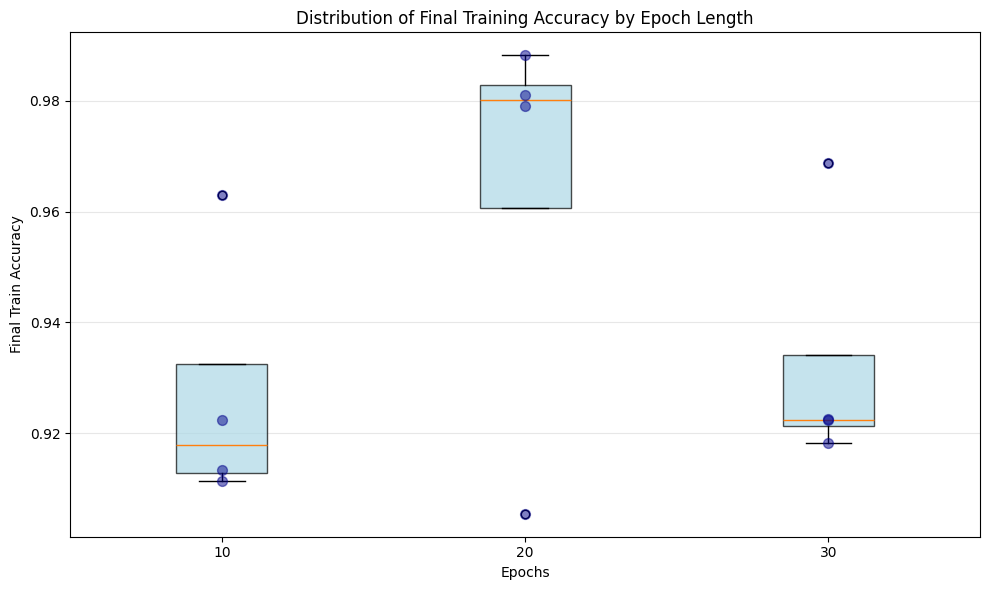

In [26]:
# Get metrics for all experiments
df_all = yr.get_metrics(tags=["results-demo"])

# Get train_accuracy for all experiments
df_acc_all = df_all[df_all.metric_name == "train_accuracy"]

# Get only the final step for each experiment (max step per experiment)
final_acc = df_acc_all.loc[df_acc_all.groupby("experiment_id")["step"].idxmax()]

print("Final accuracy values per experiment:")
print(
    final_acc[["experiment_id", "epochs", "learning_rate", "value"]].to_string(
        index=False
    )
)
print(f"\nTotal experiments: {len(final_acc)}")

# Create box plot grouped by epochs
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for box plot - group by epochs
epochs_values = sorted(final_acc.epochs.unique())
data_by_epochs = [
    final_acc[final_acc.epochs == e]["value"].values for e in epochs_values
]

# Create box plot
bp = ax.boxplot(data_by_epochs, tick_labels=epochs_values, patch_artist=True)

# Customize box plot appearance
for patch in bp["boxes"]:
    patch.set_facecolor("lightblue")
    patch.set_alpha(0.7)

# Add scatter points to show individual experiments
for i, e in enumerate(epochs_values, 1):
    y = final_acc[final_acc.epochs == e]["value"].values
    x = [i] * len(y)
    ax.scatter(x, y, alpha=0.5, s=50, color="darkblue", zorder=3)

ax.set_xlabel("Epochs")
ax.set_ylabel("Final Train Accuracy")
ax.set_title("Distribution of Final Training Accuracy by Epoch Length")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()